In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [55]:
import lalinference

In [60]:
"""
from https://git.ligo.org/lscsoft/lalsuite/blob/master/lalinference/python/lalinference/bayespputils.py
"""
def sph2cart(r,theta,phi):
    """
    Utiltiy function to convert r,theta,phi to cartesian co-ordinates.
    """
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return x,y,z


def array_dot(vec1, vec2):
    """
    Calculate dot products between vectors in rows of numpy arrays.
    """
    if vec1.ndim==1:
        product = (vec1*vec2).sum()
    else:
        product = (vec1*vec2).sum(axis=1).reshape(-1,1)
    return product

def array_ang_sep(vec1, vec2):
    """
    Find angles between vectors in rows of numpy arrays.
    """
    vec1_mag = np.sqrt(array_dot(vec1, vec1))
    vec2_mag = np.sqrt(array_dot(vec2, vec2))
    return np.arccos(array_dot(vec1, vec2)/(vec1_mag*vec2_mag))


In [61]:
"""
from https://git.ligo.org/lscsoft/lalsuite/blob/master/lalinference/python/lalinference/bayespputils.py
"""
def orbital_momentum(fref, m1,m2, inclination):
    """
    Calculate orbital angular momentum vector.
    Note: The units of Lmag are different than what used in lalsimulation.
    Mc must be called in units of Msun here.

    Note that if one wants to build J=L+S1+S2 with L returned by this function, S1 and S2
    must not get the Msun^2 factor.
    """
    eta = m1*m2/( (m1+m2)*(m1+m2) )
    Lmag = orbital_momentum_mag(fref, m1,m2,eta)
    Lx, Ly, Lz = sph2cart(Lmag, inclination, 0.0)
    return np.hstack((Lx,Ly,Lz))
#
#
def orbital_momentum_mag(fref, m1,m2,eta):
    v0 = np.power((m1+m2) *np.pi * lal.MTSUN_SI * fref, 1.0/3.0)
    #1 PN Mtot*Mtot*eta/v
    PNFirst = (((m1+m2)**2)*eta)/v0
    PNSecond = 1+ (v0**2) * (3.0/2.0 +eta/6.0)
    Lmag= PNFirst*PNSecond
    return Lmag


In [62]:
def new_gen_td_wf(p, t_min=-500, t_max=50):
    
    M = p['m1'] + p['m2']
    
    p.update({'m1':p['m1']*lal.MSUN_SI})
    p.update({'m2':p['m2']*lal.MSUN_SI})
    
    hp, hc = lalsim.SimInspiralChooseTDWaveform(**p)
    

    t = np.arange(hp.data.length) * hp.deltaT + np.float(hp.epoch)
    t = phenom.StoM(t, M)
    
    mask = (t >= t_min) & (t < t_max)
    
    hp = hp.data.data[mask]
    hc = hc.data.data[mask]
    t = t[mask]
    
#     h = hp - 1.j*hc
    
#     amp = np.abs(h)
#     phase = np.unwrap(np.angle(h))
    
    return t, hp, hc

In [63]:
base_params = lalutils.gen_td_wf_params(m2=25,
                                        f_min=10,
                                        approximant=lalsim.SEOBNRv3)

In [64]:
base_params

{'m1': 50,
 'm2': 25,
 's1x': 0,
 's1y': 0,
 's1z': 0,
 's2x': 0,
 's2y': 0,
 's2z': 0,
 'distance': 1,
 'inclination': 0,
 'phiRef': 0,
 'longAscNodes': 0,
 'eccentricity': 0,
 'meanPerAno': 0,
 'deltaT': 0.000244140625,
 'f_min': 10,
 'f_ref': 30,
 'params': None,
 'approximant': 45}

In [207]:
def _make_waveform(
    theta_jn, phi_jl, phase,
    tilt_1, tilt_2, phi_12, a_1, a_2,
    mass1, mass2,
    f_min,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-1000,
    t_max=100,
    npts=1000
):
    
    if f_ref == None:
        f_ref = f_min

    
    # get spins
    iota, s1x, s1y, s1z, s2x, s2y, s2z = \
        lalsim.SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
            a_1, a_2, mass1 * lal.MSUN_SI, mass2 * lal.MSUN_SI,
            float(f_ref), float(phase))
    
    base_params = lalutils.gen_td_wf_params(m1=mass1, m2=mass2,
                                            S1x=s1x, S1y=s1y, S1z=s1z, S2x=s2x, S2y=s2y, S2z=s2z,
                                            inclination=iota,
                                            phiRef=phase,
                                            f_min=f_min,
                                            approximant=approximant)
    
    
    t, hp, hc = new_gen_td_wf(base_params, t_min=t_min, t_max=t_max)
    
    # resample to common times
    new_t = np.linspace(t_min, t_max, npts)
    hp = IUS(t, hp)(new_t)
    hc = IUS(t, hc)(new_t)
    
    return new_t, hp, hc

In [209]:
t, hp, hc = _make_waveform(
    theta_jn=0, phi_jl=0, phase=0,
    tilt_1=0, tilt_2=0, phi_12=0, a_1=0, a_2=0,
    mass1=30, mass2=20,
    f_min=30,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-1000,
    t_max=100)

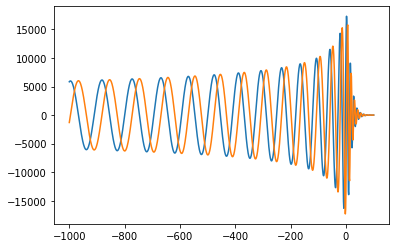

In [210]:
plt.figure()
plt.plot(t, hp)
plt.plot(t, hc)

In [211]:
def calculate_dphi(theta_JN, phi_JL, beta):
    """Calculate the difference between the phase with respect to the total
    angular momentum and the phase with respect to the orbital angular
    momentum
    """
    if theta_JN == 0:
        return 0.
    n = np.array([np.sin(theta_JN), 0, np.cos(theta_JN)])
    j = np.array([0, 0, 1])
    l = np.array([
        np.sin(beta) * np.sin(phi_JL), np.sin(beta) * np.cos(phi_JL), np.cos(beta)
    ])
    e_j = np.cross(j, l)
    e_j /= np.linalg.norm(e_j)
    e_n = np.cross(n, l)
    e_n /= np.linalg.norm(e_n)
    cosine = np.inner(e_j, e_n)
    sine = np.inner(l, np.cross(e_j, e_n))
    dphi = np.sign(sine) * np.arccos(cosine)
    return dphi

        
def calculate_dpsi(theta_JN, phi_JL, beta):
    """Calculate the difference between the polarization with respect to the
    total angular momentum and the polarization with respect to the orbital
    angular momentum
    """
    if theta_JN == 0:
        return 0.
    n = np.array([np.sin(theta_JN), 0, np.cos(theta_JN)])
    j = np.array([0, 0, 1])
    l = np.array([
        np.sin(beta) * np.sin(phi_JL), np.sin(beta) * np.cos(phi_JL), np.cos(beta)
    ])
    p_j = np.cross(n,j)
    p_j /= np.linalg.norm(p_j)
    p_l = np.cross(n, l)
    p_l /= np.linalg.norm(p_l)
    cosine = np.inner(p_j, p_l)
    sine = np.inner(n, np.cross(p_j, p_l))
    dpsi = np.sign(sine) * np.arccos(cosine)
    return dpsi

In [219]:
def make_waveform(
    theta_jn, phi_jl, phase, psi_J,
    tilt_1, tilt_2, phi_12, a_1, a_2,
    mass1, mass2,
    f_min,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-1000,
    t_max=100,
    npts=1000
):
    
    if f_ref == None:
        f_ref = f_min
    
    t, hp, hc = _make_waveform(
        theta_jn=theta_jn,
        phi_jl=phi_jl,
        phase=phase,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        a_1=a_1,
        a_2=a_2,
        mass1=mass1,
        mass2=mass2,
        f_min=f_min,
        approximant=approximant,
        f_ref=f_ref,
        t_min=t_min,
        t_max=t_max,
        npts=npts
    )
    
    # calculate beta
    
    # get spins
    iota, s1x, s1y, s1z, s2x, s2y, s2z = \
        lalsim.SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
            a_1, a_2, mass1 * lal.MSUN_SI, mass2 * lal.MSUN_SI,
            float(f_ref), float(phase))
    
    L  = orbital_momentum(f_ref, mass1, mass2, iota)
    mass1_2 = mass1*mass1
    mass2_2 = mass2*mass2
    S1 = np.hstack([mass1_2*s1x,mass1_2*s1y,mass1_2*s1z])
    S2 = np.hstack([mass2_2*s2x,mass2_2*s2y,mass2_2*s2z])
    J = L + S1 + S2
    beta = array_ang_sep(J,L)
    
    
    dpsi = calculate_dpsi(theta_jn, phi_jl, beta)
    fp = np.cos(2 * (psi_J + dpsi))
    fc = np.sin(2 * (psi_J + dpsi))
    h = (fp * hp + fc * hc)
    
    hcomplex = h.astype('complex128')
    hcomplex *= np.exp(2j * calculate_dphi(theta_jn, phi_jl, beta))
    
    # is this correct?
    h = np.real(hcomplex)
    
    
    
    return t, h

In [220]:
t, h = make_waveform(
    theta_jn=0, phi_jl=0, phase=0, psi_J=0,
    tilt_1=0, tilt_2=0, phi_12=0, a_1=0, a_2=0,
    mass1=30, mass2=20,
    f_min=30,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-1000,
    t_max=100)

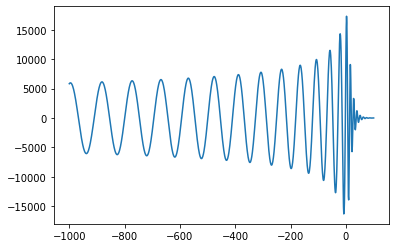

In [221]:
plt.figure()
plt.plot(t, h)

In [222]:
def calculate_precessing_harmonics(
    theta_jn_fiducial,
    tilt_1, tilt_2, phi_12, a_1, a_2,
    mass1, mass2,
    f_min,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-1000,
    t_max=100,
    npts=1000,
    harmonics=[0, 1, 2, 3, 4]
):
    """
    theta_jn_fiducial, just used for the fiducial waveform and plotting
    """
    
    t, hp, hc = _make_waveform(
        theta_jn=theta_jn_fiducial,
        phi_jl=0,
        phase=0,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        a_1=a_1,
        a_2=a_2,
        mass1=mass1,
        mass2=mass2,
        f_min=f_min,
        approximant=approximant,
        f_ref=f_ref,
        t_min=t_min,
        t_max=t_max,
        npts=npts
    )
    
    
    
    harm = {}
    if (0 in harmonics) or (4 in harmonics):
        
        _, h0 = make_waveform(
            theta_jn=0,
            phi_jl=0,
            phase=0,
            psi_J=0,
            tilt_1=tilt_1,
            tilt_2=tilt_2,
            phi_12=phi_12,
            a_1=a_1,
            a_2=a_2,
            mass1=mass1,
            mass2=mass2,
            f_min=f_min,
            approximant=approximant,
            f_ref=f_ref,
            t_min=t_min,
            t_max=t_max,
            npts=npts
        )
        
        _, hpi4 = make_waveform(
                    theta_jn=0,
                    phi_jl=0,
                    phase=np.pi/4,
                    psi_J=np.pi/4,
                    tilt_1=tilt_1,
                    tilt_2=tilt_2,
                    phi_12=phi_12,
                    a_1=a_1,
                    a_2=a_2,
                    mass1=mass1,
                    mass2=mass2,
                    f_min=f_min,
                    approximant=approximant,
                    f_ref=f_ref,
                    t_min=t_min,
                    t_max=t_max,
                    npts=npts
                )

        if (0 in harmonics):
            harm[0] = (h0 + hpi4) / 2
        if (4 in harmonics):
            harm[4] = (h0 - hpi4) / 2
            
            
    if (1 in harmonics) or (3 in harmonics):
        
        _, h0 = make_waveform(
            theta_jn=np.pi/2,
            phi_jl=0,
            phase=np.pi/4,
            psi_J=np.pi/4,
            tilt_1=tilt_1,
            tilt_2=tilt_2,
            phi_12=phi_12,
            a_1=a_1,
            a_2=a_2,
            mass1=mass1,
            mass2=mass2,
            f_min=f_min,
            approximant=approximant,
            f_ref=f_ref,
            t_min=t_min,
            t_max=t_max,
            npts=npts
        )

        
        _, hpi2 = make_waveform(
            theta_jn=np.pi/2,
            phi_jl=np.pi/2,
            phase=0,
            psi_J=np.pi/4,
            tilt_1=tilt_1,
            tilt_2=tilt_2,
            phi_12=phi_12,
            a_1=a_1,
            a_2=a_2,
            mass1=mass1,
            mass2=mass2,
            f_min=f_min,
            approximant=approximant,
            f_ref=f_ref,
            t_min=t_min,
            t_max=t_max,
            npts=npts
        )

        if (1 in harmonics):
            harm[1] = -1. * (h0 + hpi2) / 4
        if (3 in harmonics):
            harm[3] = -1. * (h0 - hpi2) / 4
            
    if (2 in harmonics):
        
        _, h0 = make_waveform(
            theta_jn=np.pi/2,
            phi_jl=0,
            phase=0,
            psi_J=0,
            tilt_1=tilt_1,
            tilt_2=tilt_2,
            phi_12=phi_12,
            a_1=a_1,
            a_2=a_2,
            mass1=mass1,
            mass2=mass2,
            f_min=f_min,
            approximant=approximant,
            f_ref=f_ref,
            t_min=t_min,
            t_max=t_max,
            npts=npts
        )
        
        _, hpi2 = make_waveform(
            theta_jn=np.pi/2,
            phi_jl=np.pi/2,
            phase=0,
            psi_J=0,
            tilt_1=tilt_1,
            tilt_2=tilt_2,
            phi_12=phi_12,
            a_1=a_1,
            a_2=a_2,
            mass1=mass1,
            mass2=mass2,
            f_min=f_min,
            approximant=approximant,
            f_ref=f_ref,
            t_min=t_min,
            t_max=t_max,
            npts=npts
        )
        
        harm[2] = (h0 + hpi2) / 6
            
    return t, hp, hc, harm

In [268]:
t, hp, hc, harm = calculate_precessing_harmonics(
    theta_jn_fiducial=0,
    tilt_1=np.pi/2.1, tilt_2=0, phi_12=0, a_1=0.99, a_2=0.,
    mass1=34.2, mass2=5.7,
    f_min=20,
    approximant=lalsim.SEOBNRv3,
    f_ref=None,
    t_min=-3000,
    t_max=100,
    npts=5000,
    harmonics=[0, 1, 2, 3, 4]
)

(-400, 100)

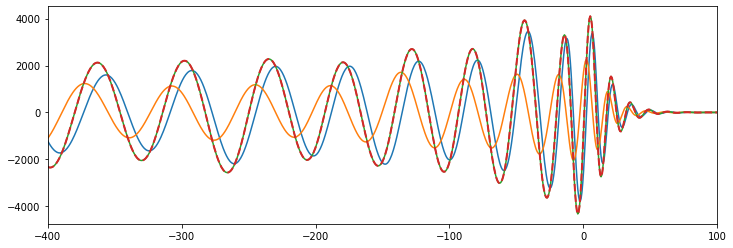

In [278]:
plt.figure(figsize=(12,4))

plt.plot(t, harm[0])
plt.plot(t, harm[4])
plt.plot(t, harm[0] + harm[4])
plt.plot(t, hp, lw=2, ls='--')
# plt.xlim(-1000, 100)
plt.xlim(-400, 100)

(-1000, 100)

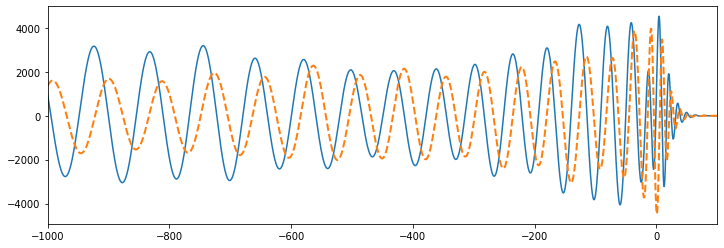

In [294]:
plt.figure(figsize=(12,4))

plt.plot(t, harm[0] + harm[1] + harm[3] + harm[4])
plt.plot(t, hc, lw=2, ls='--')
plt.xlim(-1000, 100)

(-1000, 100)

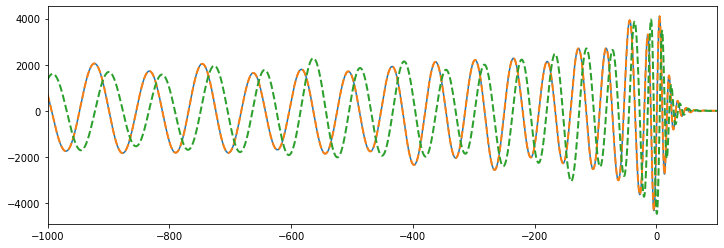

In [295]:
plt.figure(figsize=(12,4))

# plt.plot(t, harm[0])
# plt.plot(t, harm[4])
plt.plot(t, harm[0] + harm[4])
# plt.plot(t, harm[1])
# plt.plot(t, harm[3])
# plt.plot(t, harm[2])
plt.plot(t, hp, lw=2, ls='--')
plt.plot(t, hc, lw=2, ls='--')
plt.xlim(-1000, 100)